# Load imports

In [28]:
# Core Packages
import os
import pandas as pd
import numpy as np

# # Data pre-processing
# from sklearn.preprocessing import StandardScaler

# Clustering algorithms
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN

# Attempting to import KernelKMeans
try:
    from sklearn_extra.cluster import KernelKMeans
    HAVE_KERNEL_KMEANS = True
except Exception:
    HAVE_KERNEL_KMEANS = False
    print("KernelKmeans Unavailable")

# Attempting to import DENCLUE/PROCLUS
try:
    from pyclustering.cluster.denclue import denclue, kernel_function_type
    from pyclustering.cluster.proclus import proclus
    HAVE_PYCLUSTERING = True
except Exception:
    HAVE_PYCLUSTERING = False
    denclue = kernel_function_type = proclus = None
    print("DENCLUE, PROCLUS Unavailable")

# Attempting to import KmeansConstrained
try:
    from k_means_constrained import KMeansConstrained
    HAVE_KMEANS_CONSTRAINED = True
except Exception:
    HAVE_KMEANS_CONSTRAINED = False
    KMeansConstrained = None
    print("KMeansConstrained Unavailable.")

# Clustering Evaluation metrics
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For Reproducibility
RANDOM_STATE = 42

# Creating output directory for clustering .csvs
OUTPUT_DIR = os.path.join("csv_files", "csv_cluster_files")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Helper function for saving a DataFrame to our output directory
def save_csv(df, name):
    """Write CSV to csv_files/csv_cluster_files/<name>.csv with index=False."""
    df.to_csv(os.path.join(OUTPUT_DIR, f"{name}.csv"), index=False)

# Global Variable to use for debugging purposes in relation to Ryan's previous scaling
USE_STANDARD_SCALER_EXPERIMENT = False

KernelKmeans Unavailable
DENCLUE, PROCLUS Unavailable


# Load Processed PCA datasets

### Clustering on PCA features
Using the PCA outputs from cluster_feature_selection.ipynb (Ryan). We search a few clustering families (KMeans, Agglomerative, Spectral, DBSCAN), rank by silhouette/CH/DB, and export cluster assignments + profiles for downstream analysis.

In [29]:
# Loading .CSV files created in cluster_feature_selection.ipynb (Ryan)
bat_path = "csv_files/batters_pca_features.csv"
pit_path = "csv_files/pitchers_pca_features.csv"

batters_df = pd.read_csv(bat_path)
pitchers_df = pd.read_csv(pit_path)

# identifier and non-feature columns (we keep Salary because it's already normalized per-year in Ryan's step)
id_col = "Name"
non_feature_cols = {id_col, "Team", "Year"}

# feature matrices for clustering
bat_feature_cols = [c for c in batters_df.columns if c not in non_feature_cols]
pit_feature_cols = [c for c in pitchers_df.columns if c not in non_feature_cols]

X_bat = batters_df[bat_feature_cols]
X_pit = pitchers_df[pit_feature_cols]

# For debugging purposes is scale is an issue
if USE_STANDARD_SCALER_EXPERIMENT:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_bat = pd.DataFrame(scaler.fit_transform(X_bat), columns=bat_feature_cols)
    X_pit = pd.DataFrame(scaler.fit_transform(X_pit), columns=pit_feature_cols)

In [30]:
print(f"[Batters] rows={len(X_bat):,}, cols={len(X_bat.columns)}")
print(f"[Pitchers] rows={len(X_pit):,}, cols={len(X_pit.columns)}")
display(X_bat.head(3))
display(X_pit.head(3))

[Batters] rows=5,450, cols=10
[Pitchers] rows=5,495, cols=13


,Overall_Offensive_Production,Speed_and_Baserunning_Aggression,Contact_and_OnBase_Efficiency,Experience_and_Longevity,Plate_Toughness_and_Intentionality,Situational_Contact_Hitting,Patience_vs_Strikeout_Profile,Gap_Power_and_Doubles_Ability,Productive_Baserunning,Salary
0,6.000405,1.585444,0.357066,-1.641773,1.802005,-0.619777,1.604060,-1.885356,1.348817,1.925225
1,3.827357,1.994843,-1.001717,-0.846473,-0.548212,-1.556538,-0.326493,-0.565544,0.167803,2.168257
2,2.029447,2.107021,-0.420237,0.318406,-0.235169,-1.450602,0.242976,-0.147753,-1.532303,-1.792468


,Workload_and_Volume,Run_Prevention,Command_and_Control,Stamina_and_CompleteGames,Bullpen_Leverage,Strikeout_Dominance,Veteran_Pitching_Style,Mechanical_Volatility,Pressure_Composure,Relief_Effectiveness,Overall_Performance_Value,Sabermetric_Efficiency,Salary
0,3.262113,0.416926,-0.530285,-1.738596,-0.582734,0.328378,0.45463,-0.876445,0.215656,-1.040292,0.827779,0.432365,5.621204
1,3.262113,0.416926,-0.530285,-1.738596,-0.582734,0.328378,0.45463,-0.876445,0.215656,-1.040292,0.827779,0.432365,5.621204
2,2.857388,3.757410,1.192545,-0.307011,-1.208139,0.629566,0.39461,0.734392,1.362479,0.010549,-0.845647,0.232409,1.887012


# Define Clustering Utilities

We evaluate several clustering approaches. KMeans is our primary baseline (Ryan’s PCA space is well-suited). Spectral acts as a kernelized KMeans analogue. Agglomerative provides a hierarchical check. DBSCAN gives a density-based view. We report silhouette, Calinski–Harabasz, Davies–Bouldin.

In [32]:
def score_clusters(X, labels):
    """Return common clustering metrics; handle single/noise cluster edge cases."""
    n = len(set(labels)) - (1 if -1 in labels else 0)
    if n < 2:
        return {
            "silhouette": np.nan,
            "calinski": np.nan,
            "davies": np.nan,
            "n_clusters": n,
        }
    return {
        "silhouette": silhouette_score(X, labels),
        "calinski": calinski_harabasz_score(X, labels),
        "davies": davies_bouldin_score(X, labels),
        "n_clusters": n,
    }

def run_kmeans_grid(X, ks=range(3, 11), random_state=RANDOM_STATE):
    rows = []
    for k in ks:
        model = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
        labels = model.fit_predict(X)
        rows.append(
            score_clusters(X, labels) | {"method": "kmeans", "k": k, "model": model}
        )
    return pd.DataFrame(rows)

def run_kmeans_constrained_grid(
    X,
    ks=range(3, 11),
    size_fracs=(0.02, 0.03, 0.05),
    max_size_frac=0.40,
    random_state=RANDOM_STATE,
):
    """Run K-Means with min/max cluster size constraints."""
    rows = []
    n = len(X)
    for k in ks:
        for f in size_fracs:
            min_size = max(1, int(f * n))
            max_size = int(max_size_frac * n) if max_size_frac else None

            model = KMeansConstrained(
                n_clusters=k,
                size_min=min_size,
                size_max=max_size,
                random_state=random_state,
                n_init=10,
            )
            labels = model.fit_predict(X)
            rows.append(
                score_clusters(X, labels)
                | {
                    "method": "kmeans_constrained",
                    "k": k,
                    "min_size": min_size,
                    "max_size": max_size,
                    "model": model,
                }
            )
    return pd.DataFrame(rows)

def run_agglomerative_grid(X, ks=range(3, 11)):
    rows = []
    for k in ks:
        model = AgglomerativeClustering(n_clusters=k, linkage="ward")
        labels = model.fit_predict(X)
        rows.append(
            score_clusters(X, labels)
            | {"method": "agglomerative", "k": k, "model": model}
        )
    return pd.DataFrame(rows)

def run_spectral_grid(X, ks=range(3, 11), random_state=RANDOM_STATE):
    rows = []
    for k in ks:
        model = SpectralClustering(
            n_clusters=k,
            assign_labels="kmeans",
            affinity="rbf",
            gamma=1.0 / X.shape[1],
            random_state=random_state,
        )
        labels = model.fit_predict(X)
        rows.append(
            score_clusters(X, labels) | {"method": "spectral", "k": k, "model": model}
        )
    return pd.DataFrame(rows)

def run_dbscan_grid(X, eps_list=(0.5, 1.0, 1.5, 2.0), min_samples_list=(5, 10)):
    rows = []
    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X)
            rows.append(
                score_clusters(X, labels)
                | {"method": "dbscan", "eps": eps, "min_samples": ms, "model": model}
            )
    return pd.DataFrame(rows)

def rank_models(search_df):
    """
    Rank by silhouette (desc), then Calinski–Harabasz (desc), then Davies–Bouldin (asc).
    Exclude degenerate configs: fewer than 2 clusters or NaN metrics.
    """
    d = search_df.copy()
    d = d[(d["n_clusters"] >= 2)]
    d = d.dropna(subset=["silhouette", "calinski", "davies"])

    if d.empty:
        raise RuntimeError("No viable clustering result (>=2 clusters with valid metrics).")

    d["davies_inv"] = -d["davies"]
    d = (
        d.assign(
            r_sil=lambda t: t["silhouette"].rank(ascending=False, method="min"),
            r_cal=lambda t: t["calinski"].rank(ascending=False, method="min"),
            r_dav=lambda t: t["davies_inv"].rank(ascending=False, method="min"),
        )
        .assign(rank_score=lambda t: t.r_sil * 100 + t.r_cal * 0.01 + t.r_dav * 0.0001)
        .sort_values("rank_score")
    )
    return d


# Grid Search Across Methods

Search K=3…10 for the centroid/hierarchical models; small grids for DBSCAN (eps ∈ {0.5,1.0,1.5,2.0}, min_samples ∈ {5,10}). Save complete metrics for both datasets.

In [33]:
bat_search = pd.concat(
    [
        run_kmeans_grid(X_bat),
        run_kmeans_constrained_grid(X_bat),
        run_agglomerative_grid(X_bat),
        run_spectral_grid(X_bat),
        run_dbscan_grid(X_bat),
    ],
    ignore_index=True,
)

pit_search = pd.concat(
    [
        run_kmeans_grid(X_pit),
        run_kmeans_constrained_grid(X_pit),
        run_agglomerative_grid(X_pit),
        run_spectral_grid(X_pit),
        run_dbscan_grid(X_pit),
    ],
    ignore_index=True,
)

# Persist metrics for review
save_csv(bat_search, "batters_clustering_metrics")
save_csv(pit_search, "pitchers_clustering_metrics")

# Quick looks
print("Batters — n_clusters value counts:")
display(bat_search["n_clusters"].value_counts().sort_index())

print("Pitchers — n_clusters value counts:")
display(pit_search["n_clusters"].value_counts().sort_index())

print("Top 10 by silhouette (batters):")
display(bat_search.sort_values("silhouette", ascending=False).head(10))

print("Top 10 by silhouette (pitchers):")
display(pit_search.sort_values("silhouette", ascending=False).head(10))


Batters — n_clusters value counts:


n_clusters
0     2
1     2
2     1
3     6
4     7
5     6
6     6
7     6
8     7
9     6
10    6
15    1
Name: count, dtype: int64

Pitchers — n_clusters value counts:


n_clusters
0     4
3     7
4     6
5     7
6     6
7     6
8     6
9     6
10    6
15    1
20    1
Name: count, dtype: int64

Top 10 by silhouette (batters):


,silhouette,calinski,davies,n_clusters,method,k,model,min_size,max_size,eps,min_samples
41,0.387535,45.500047,1.172591,4,spectral,4.0,"SpectralClustering(gamma=0.1, n_clusters=4, ra...",NaN,NaN,NaN,NaN
40,0.384224,121.684949,2.957095,3,spectral,3.0,"SpectralClustering(gamma=0.1, n_clusters=3, ra...",NaN,NaN,NaN,NaN
45,0.325918,50.238578,1.849667,8,spectral,8.0,"SpectralClustering(gamma=0.1, random_state=42)",NaN,NaN,NaN,NaN
43,0.317501,56.707702,1.427083,6,spectral,6.0,"SpectralClustering(gamma=0.1, n_clusters=6, ra...",NaN,NaN,NaN,NaN
42,0.303427,85.875995,1.589317,5,spectral,5.0,"SpectralClustering(gamma=0.1, n_clusters=5, ra...",NaN,NaN,NaN,NaN
44,0.302658,64.313277,1.753811,7,spectral,7.0,"SpectralClustering(gamma=0.1, n_clusters=7, ra...",NaN,NaN,NaN,NaN
46,0.291637,65.726059,1.859286,9,spectral,9.0,"SpectralClustering(gamma=0.1, n_clusters=9, ra...",NaN,NaN,NaN,NaN
47,0.288506,56.564916,2.213425,10,spectral,10.0,"SpectralClustering(gamma=0.1, n_clusters=10, r...",NaN,NaN,NaN,NaN
10,0.225938,1847.237243,1.663252,3,kmeans_constrained,3.0,"KMeansConstrained(copy_x=True, init='k-means++...",272.0,2180.0,NaN,NaN
8,0.225894,1847.233947,1.663485,3,kmeans_constrained,3.0,"KMeansConstrained(copy_x=True, init='k-means++...",109.0,2180.0,NaN,NaN


Top 10 by silhouette (pitchers):


,silhouette,calinski,davies,n_clusters,method,k,model,min_size,max_size,eps,min_samples
40,0.611359,20.896062,0.315747,3,spectral,3.0,"SpectralClustering(gamma=0.07692307692307693, ...",NaN,NaN,NaN,NaN
43,0.475551,21.742961,0.885459,6,spectral,6.0,"SpectralClustering(gamma=0.07692307692307693, ...",NaN,NaN,NaN,NaN
42,0.458013,57.638691,0.787064,5,spectral,5.0,"SpectralClustering(gamma=0.07692307692307693, ...",NaN,NaN,NaN,NaN
46,0.441895,27.176478,0.661137,9,spectral,9.0,"SpectralClustering(gamma=0.07692307692307693, ...",NaN,NaN,NaN,NaN
45,0.437842,32.651798,0.857693,8,spectral,8.0,"SpectralClustering(gamma=0.07692307692307693, ...",NaN,NaN,NaN,NaN
44,0.430435,46.022060,0.923457,7,spectral,7.0,"SpectralClustering(gamma=0.07692307692307693, ...",NaN,NaN,NaN,NaN
41,0.405685,86.318894,1.343673,4,spectral,4.0,"SpectralClustering(gamma=0.07692307692307693, ...",NaN,NaN,NaN,NaN
47,0.364973,45.408212,1.175447,10,spectral,10.0,"SpectralClustering(gamma=0.07692307692307693, ...",NaN,NaN,NaN,NaN
32,0.204348,1263.753005,1.754005,3,agglomerative,3.0,AgglomerativeClustering(n_clusters=3),NaN,NaN,NaN,NaN
18,0.165408,1047.728982,1.620827,6,kmeans_constrained,6.0,"KMeansConstrained(copy_x=True, init='k-means++...",164.0,2198.0,NaN,NaN


# Fit Best Models and Export Results

### Model selection and export

Pick the top-ranked config per dataset, fit once more, then persist two artifacts:

cluster assignments (Name → cluster)

cluster profiles (feature means by cluster)

In [ ]:
from sklearn.base import clone

def _instantiate_fresh_model(best_row):
    """
    Rebuild a *fresh, unfitted* estimator using the exact params
    of the winning model from the grid search.
    """
    fitted = best_row["model"]              # this is the model that scored in the grid
    fresh  = clone(fitted)                  # same class + same init params, unfitted
    # ensure determinism if the model exposes random_state
    if hasattr(fresh, "random_state"):
        fresh.set_params(random_state=RANDOM_STATE)
    return fresh


def fit_best_and_export(search_df, X, raw_df, label):
    # ----- select winning configuration -----
    ranked = rank_models(search_df)          # filters degenerate rows internally
    best = ranked.iloc[0]                    # top by composite rank
    model = _instantiate_fresh_model(best)

    # ----- fit on full feature matrix -----
    clusters = model.fit_predict(X)

    clusters = model.fit_predict(X)
    vals, cnts = np.unique(clusters, return_counts=True)
    print(f"[{label}] unique labels: {vals.tolist()}  counts: {cnts.tolist()}")

    # ----- build & save assignments (Name[, Team, Year] → cluster) -----
    id_col = "Name"
    meta_cols = [c for c in [id_col, "Team", "Year"] if c in raw_df.columns]
    assign = raw_df[meta_cols].copy()
    assign["cluster"] = clusters
    assign_name = f"{label}_cluster_assignments"
    save_csv(assign, assign_name)

    # ----- build & save cluster profiles (mean of features by cluster) -----
    # use X's column names if available (DataFrame); otherwise create generic names
    X_df = pd.DataFrame(X, columns=X.columns if hasattr(X, "columns") else None).copy()
    X_df["cluster"] = clusters
    prof = (
        X_df.groupby("cluster")
            .mean(numeric_only=True)
            .reset_index()
            .sort_values("cluster")
    )
    prof_name = f"{label}_cluster_profiles"
    save_csv(prof, prof_name)

    # ----- friendly log -----
    print(f"[{label}] best:", {k: best.get(k) for k in ["method", "k", "eps", "min_samples", "n_clusters"]})
    print("saved:",
          os.path.join(OUTPUT_DIR, f"{assign_name}.csv"),
          "and",
          os.path.join(OUTPUT_DIR, f"{prof_name}.csv"))

    return assign, prof, best


# ----- run for batters and pitchers -----
bat_assign, bat_prof, bat_best = fit_best_and_export(
    bat_search, X_bat, batters_df, label="batters"
)
pit_assign, pit_prof, pit_best = fit_best_and_export(
    pit_search, X_pit, pitchers_df, label="pitchers"
)

# quick peek
display(bat_assign.head())
display(pit_assign.head())

# sanity: show cluster counts (should not all be 0 now)
print("Batters cluster counts:")
display(bat_assign["cluster"].value_counts().sort_index())
print("Pitchers cluster counts:")
display(pit_assign["cluster"].value_counts().sort_index())

[batters] unique labels: [0, 1, 2, 3]  counts: [5428, 4, 16, 2]
[batters] best: {'method': 'spectral', 'k': np.float64(4.0), 'eps': np.float64(nan), 'min_samples': np.float64(nan), 'n_clusters': np.int64(4)}
saved: csv_files/csv_cluster_files/batters_cluster_assignments.csv and csv_files/csv_cluster_files/batters_cluster_profiles.csv


# Visualize Clusters

### Quick visualization

2D scatter for a fast sanity check. Axes pick meaningful PCA features when available, else the first two.

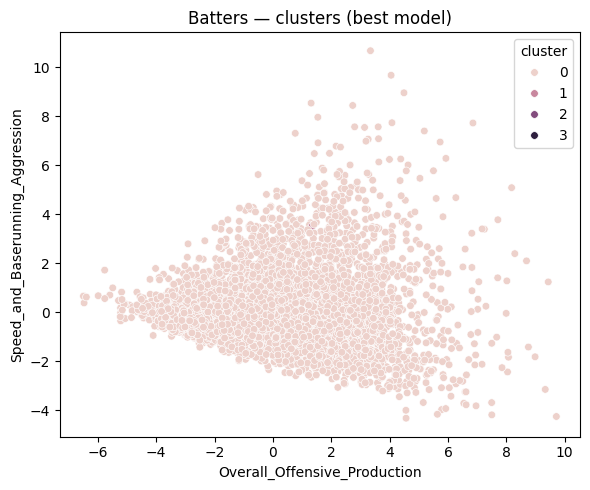

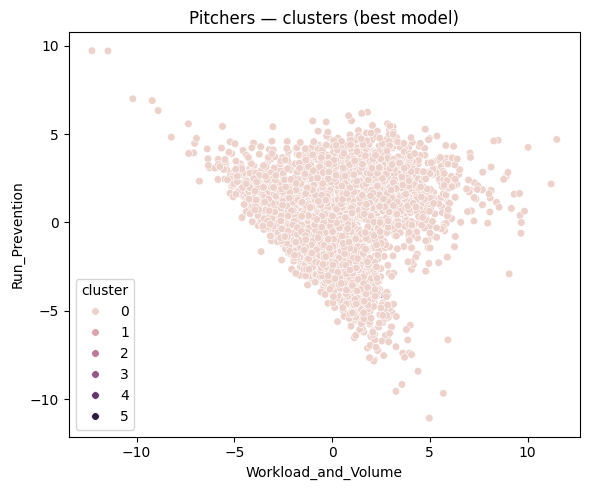

In [8]:
def quick_scatter(df, x, y, hue_col="cluster", title=""):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(data=df, x=x, y=y, hue=hue_col, s=30)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# choose sensible axes by name; fall back to the first two features
bat_x = next((c for c in X_bat.columns if "Offensive" in c), X_bat.columns[0])
bat_y = next((c for c in X_bat.columns if "Speed" in c), X_bat.columns[1])

pit_x = next((c for c in X_pit.columns if "Workload" in c), X_pit.columns[0])
pit_y = next((c for c in X_pit.columns if "Run_Prevention" in c), X_pit.columns[1])

bat_vis = batters_df[[id_col, "Team", "Year"]].merge(bat_assign, on=id_col, how="left").join(X_bat)
pit_vis = pitchers_df[[id_col, "Team", "Year"]].merge(pit_assign, on=id_col, how="left").join(X_pit)

quick_scatter(bat_vis, bat_x, bat_y, "cluster", "Batters — clusters (best model)")
quick_scatter(pit_vis, pit_x, pit_y, "cluster", "Pitchers — clusters (best model)")

For Charles if helpful: per team counts by cluster for feeding a downstream regression

In [9]:
if "Team" in batters_df.columns:
    bat_team_counts = (
        bat_vis.pivot_table(index="Team", columns="cluster", aggfunc="size", fill_value=0)
        .sort_index(axis=1)
    )
    save_csv(bat_team_counts, "team_cluster_counts_batters")

if "Team" in pitchers_df.columns:
    pit_team_counts = (
        pit_vis.pivot_table(index="Team", columns="cluster", aggfunc="size", fill_value=0)
        .sort_index(axis=1)
    )
    save_csv(pit_team_counts, "team_cluster_counts_pitchers")